In [1]:
from astropy.io import fits
quasar_cata = fits.getdata('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/SDSS16Q/DR16Q_v4.fits')

In [2]:
import astropy.coordinates as coo
import astropy.units as u

In [3]:
c = coo.SkyCoord(ra=quasar_cata['RA']*u.degree, dec=quasar_cata['DEC']*u.degree)

In [11]:
c.galactic.l.to(u.degree).value.max()

359.99924790038665

In [13]:
c.galactic.b.to(u.degree).value.max()

89.97336844550946

In [3]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

In [4]:
mask = hp.read_map('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/mask/mask.fits')
dat = hp.read_alm('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/MV/dat_klm.fits')

image = hp.sphtfunc.alm2map(dat, nside=2048, pol=False)
image_masked = hp.ma(image)
image_masked.mask = np.logical_not(mask)

In [5]:
pos = hp.ang2vec(theta=np.deg2rad(90-dec), phi=np.deg2rad(ra))

In [6]:
size = pos.shape[0]
values = np.zeros(size)
weight = np.zeros(size)

for i in range(size):
    idx = hp.query_disc(nside=2048, vec=pos[i], radius=np.radians(1))
    choose = image_masked[idx]    
    value = choose[np.logical_not(choose.mask)].data
    values[i] = value.sum()
    weight[i] = len(value)

In [7]:
pos = hp.ang2vec(theta=np.deg2rad(90-quasar_cata['DEC']), phi=np.deg2rad(quasar_cata['RA']))

There are about 65% of overlapping.

In [41]:
import tqdm
size = pos.shape[0]
count = 0
for i in tqdm.trange(size):
    idx = hp.query_disc(nside=2048, vec=pos[i], radius=np.radians(1))
    choose = image_masked[idx]
    if not choose.mask.all():
        count += 1


100%|██████████| 750414/750414 [00:55<00:00, 13420.53it/s]


In [42]:
count

488359

In [43]:
count / len(quasar_cata)

0.6507860994064609

In [5]:
theta_bins = np.linspace(0, 120, 10)/60             # degree

In [7]:
size = len(pos)

In [9]:
import tqdm
values = np.zeros((len(theta_bins-1), size))
weight = np.zeros((len(theta_bins-1), size))
for i in range(len(theta_bins-1)):
    theta_range = theta_bins[i], theta_bins[i+1]
    for j in tqdm.trange(size):
        idx_in = hp.query_disc(nside=2048, vec=pos[i], radius=np.radians(theta_range[0]))
        idx_out = hp.query_disc(nside=2048, vec=pos[i], radius=np.radians(theta_range[1]))
        idx = np.zeros(len(image_masked), bool)
        idx[idx_out] = True
        idx[idx_in] = False
        choose = image_masked[idx]
        value = choose[np.logical_not(choose.mask)].data
        values[i,j] = value.mean()
        weight[i,j] = len(value)


  0%|          | 751/750414 [00:22<6:12:35, 33.53it/s]


KeyboardInterrupt: 

multi-processing

In [8]:
from astropy import units as u
np.linspace(1, 10, 10)*u.arcsec

<Quantity [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.] arcsec>

In [9]:
(np.linspace(1, 10, 10)*u.arcsec).to(u.degree).value

array([0.00027778, 0.00055556, 0.00083333, 0.00111111, 0.00138889,
       0.00166667, 0.00194444, 0.00222222, 0.0025    , 0.00277778])

In [11]:
from multiprocessing import Pool
from tqdm import tqdm
import time

In [34]:
mypool = Pool(10)
def func(i):
    time.sleep(0.5)
    return i


In [43]:
list(tqdm(mypool.imap(func, range(10), chunksize=1), total=10))

100%|██████████| 10/10 [00:00<00:00, 19.92it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

(array([6.660e+02, 2.789e+03, 3.311e+03, 2.345e+03, 7.240e+02, 1.410e+02,
        1.100e+01, 8.000e+00, 2.000e+00, 3.000e+00]),
 array([0.074     , 0.72550069, 1.37700138, 2.02850207, 2.68000276,
        3.33150345, 3.98300414, 4.63450483, 5.28600552, 5.93750621,
        6.5890069 ]),
 <BarContainer object of 10 artists>)

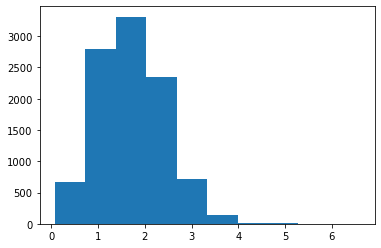

In [46]:
plt.hist(data['Z'])

In [5]:
import multiprocessing as mp
import tqdm
import time

In [25]:
def progress_bar(receiver):
    # while True:
    #     msg = receiver.recv()
    #     print(msg)
    pbar = tqdm.tqdm(total=12)
    while True:
        msg = receiver.recv()
        if msg:
            pbar.update(1)
        else:
            pbar.close()
            break    

In [26]:
send, receive = mp.Pipe()
p = mp.Process(target=progress_bar, args=(receive,))
p.start()
for i in range(10):
    time.sleep(0.3)
    send.send(1)
send.send(0)
p.join()

  0%|          | 0/12 [00:00<?, ?it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.33it/s]
